In [3]:
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
import torch
from tqdm import tqdm
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
device = "cuda"

In [4]:
model_id = "meta-llama/Meta-Llama-3-8B"

# model_id = "openai-community/gpt2-large"

# model_id = "meta-llama/Llama-2-7b-hf"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
  model_id,
  device_map='auto',
  torch_dtype=torch.bfloat16,
)

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/177 [00:00<?, ?B/s]

In [5]:
test = load_dataset("wikitext", "wikitext-2-raw-v1", split="test")
encodings = tokenizer("\n\n".join(test["text"]), return_tensors="pt")

In [6]:
max_length = min(model.config.max_position_embeddings, 4096)

stride = 512
seq_len = encodings.input_ids.size(1)

nlls = []
texts = []
tokens = []

char_norm_nlls = []

prev_end_loc = 0
for begin_loc in tqdm(range(0, seq_len, stride)):
    end_loc = min(begin_loc + max_length, seq_len)
    trg_len = end_loc - prev_end_loc  # may be different from stride on last loop
    input_ids = encodings.input_ids[:, begin_loc:end_loc].to(device)
    target_ids = input_ids.clone()
    target_ids[:, :-trg_len] = -100

    texts.append(tokenizer.decode(input_ids[0]))
    tokens.append(tokenizer.convert_ids_to_tokens(input_ids[0]))

    with torch.no_grad():
        outputs = model(input_ids, labels=target_ids)

        # loss is calculated using CrossEntropyLoss which averages over valid labels
        # N.B. the model only calculates loss over trg_len - 1 labels, because it internally shifts the labels
        # to the left by 1.
        neg_log_likelihood = outputs.loss


    nlls.append(neg_log_likelihood)

    char_norm_nlls.append((trg_len-1) * neg_log_likelihood / len(texts[-1]))

    prev_end_loc = end_loc
    if end_loc == seq_len:
        break

 99%|█████████▊| 557/565 [10:38<00:09,  1.15s/it]


In [7]:
torch.exp(torch.stack(nlls).mean())

tensor(5.3597, device='cuda:0')

In [8]:
torch.stack(nlls).mean()

tensor(1.6789, device='cuda:0')

In [9]:
torch.stack(char_norm_nlls).mean()

tensor(0.0481, device='cuda:0')

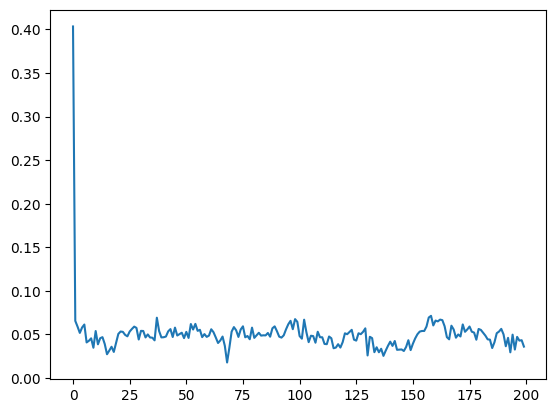

In [10]:
import matplotlib.pyplot as plt

plt.plot(torch.stack(char_norm_nlls).cpu().numpy()[:200])

(array([  1.,   2.,   0.,   6.,  10.,  27.,  38.,  56.,  77., 113.,  86.,
         61.,  40.,  24.,  13.,   3.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([0.01029953, 0.01423029, 0.01816105, 0.02209181, 0.02602257,
        0.02995332, 0.03388408, 0.03781484, 0.0417456 , 0.04567636,
        0.04960712, 0.05353788, 0.05746863, 0.06139939, 0.06533015,
        0.06926091, 0.07319167, 0.07712243, 0.08105318, 0.08498394,
        0.0889147 , 0.09284546, 0.09677622, 0.

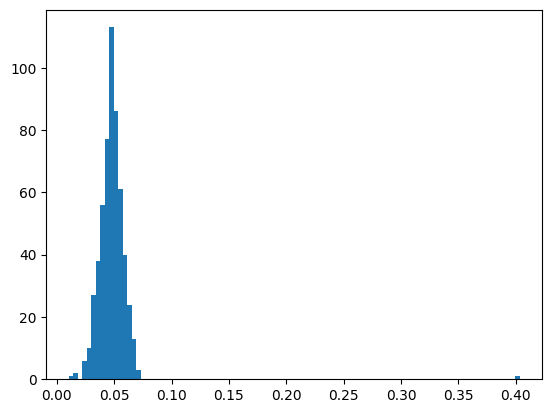

In [11]:
plt.hist([float(c) for c in char_norm_nlls], bins=100)

In [13]:
print(texts[0])

<|begin_of_text|>

 = Robert Boulter = 




 Robert Boulter is an English film, television and theatre actor. He had a guest @-@ starring role on the television series The Bill in 2000. This was followed by a starring role in the play Herons written by Simon Stephens, which was performed in 2001 at the Royal Court Theatre. He had a guest role in the television series Judge John Deed in 2002. In 2004 Boulter landed a role as " Craig " in the episode " Teddy's Story " of the television series The Long Firm ; he starred alongside actors Mark Strong and Derek Jacobi. He was cast in the 2005 theatre productions of the Philip Ridley play Mercury Fur, which was performed at the Drum Theatre in Plymouth and the Menier Chocolate Factory in London. He was directed by John Tiffany and starred alongside Ben Whishaw, Shane Zaza, Harry Kent, Fraser Ayres, Sophie Stanton and Dominic Hall. 


 In 2006, Boulter starred alongside Whishaw in the play Citizenship written by Mark Ravenhill. He appeared on 

In [15]:
print(texts[-1])

 the " major league " of professional hustling and high @-@ stakes wagering by high @-@ rollers that follows it. He throws his raw talent and ambition up against the best player in the country ; seeking to best the legendary pool player " Minnesota Fats. " After initially losing to Fats and getting involved with unscrupulous manager Bert Gordon, Eddie returns to try again, but only after paying a terrible personal price. 


 The film was shot on location in New York City. It stars Paul Newman as " Fast " Eddie Felson, Jackie Gleason as Minnesota Fats, Piper Laurie as Sarah, and George C. Scott as Bert. 


 The Hustler was a major critical and popular success, gaining a reputation as a modern classic. Its exploration of winning, losing, and character garnered a number of major awards ; it is also credited with helping to spark a resurgence in the popularity of pool. Real @-@ life pool player Rudolf Wanderone, known at the time as " New York Fats " and " Chicago Fats ", claimed to be the